# Data Mining Versuch Analyse Globaler Gesundheitsdaten

* Autor: Prof. Dr. Johannes Maucher
* Datum: 18.10.2018

**Abzugeben ist das Jupyter Notebook mit dem verlangten Implementierungen, den entsprechenden Ausgaben, Antworten und Diskussionen/Beschreibungen. Das Notebook ist als .ipynb und als .html abzugeben.**

* [Übersicht Jupyter Notebooks im Data Mining Praktikum](Data%20Mining%20Praktikum.ipynb)


# Einführung
## Lernziele:
In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Datenimport und Datenexport von und zu 
    * Pandas Dataframes
    * PostgreSQL Datenbanken
* Explorative Datenanalysen (EDA)
* Interaktive Datenvisualisierung mit Bokeh
* Dimensionsreduktion mit PCA und TSNE
* Überwachtes Lernen eines Regressionsmodells
* Unüberwachtes Lernen mit K-Means
* Zeitreihen-Visualisierung

## Vorbereitung

### Datenbankzugriff
1. Installieren Sie PostgreSQL. Mit PostgreSQL sollte auch pgAdmin installiert werden. PgAdmin ist eine open-source Software für die Entwicklung und die Administration von PostgreSQL Datenbanken.
2. Legen Sie über pgAdmin eine Datenbank für das Datamining-Praktikum an. In diese Datenbank werden alle in diesem Versuch relevanten Tabellen geschrieben.
3. Für den Datenbankzugriff aus Python heraus wird in diesem Versuch [SQLAlchemy](http://docs.sqlalchemy.org/en/latest/intro.html) eingesetzt. Machen Sie sich mit den Basics von SQLAlchemy vertraut, z.B. mithilfe von [https://gitlab.mi.hdm-stuttgart.de/maucher/DataScienceProgramming/blob/master/Python/Lecture/07DataBasePandas.ipynb](https://gitlab.mi.hdm-stuttgart.de/maucher/DataScienceProgramming/blob/master/Python/Lecture/07DataBasePandas.ipynb), Abschnitt *Using SQLAlchemy and Pandas*.

### Pandas Dataframe

Machen Sie sich mit den Grundlagen von Pandas vertraut.

### Visualisierung mit Bokeh

Machen Sie sich mit den Grundlagen von [Bokeh](https://bokeh.pydata.org/en/latest/docs/user_guide/quickstart.html) vertraut.

### Dimensionsreduktion
Machen Sie sich mit der Hauptachsentransformation (PCA) und dem t-SNE Verfahren vertraut.

### Regression

Machen Sie sich mit Linearer Regression und Random Forest Regression vertraut.

### Clustering

Machen Sie sich mit dem k-means Clustering Algorithmus vertraut.


# Durchführung

## Einlesen der Daten aus .csv und Ablage in PostgreSQL
In diesem ersten Teil des Versuchs müssen alle relevanten Daten aus .csv-Files eingelesen und in PostgreSQL-Tabellen abgelegt werden. Alle benötigten .csv Files befinden sich im Verzeichnis `gesundheitsdaten`. Die Daten stammen aus folgenden Quellen:

- allgemeine Daten pro Land und Jahr, wie:
    - Lebenserwartung (https://ourworldindata.org/life-expectancy)
    - BIP pro Kopf (https://ourworldindata.org/economic-growth)
    - Gesundheitsausgaben pro Kopf (https://ourworldindata.org/financing-healthcare)
    - Jahresarbeitsstunden pro Kopf (https://ourworldindata.org/working-hours)
- Ernährungsdaten pro Land und Jahr, wie: (https://ourworldindata.org/diet-compositions)
    - durchschnittliche zugeführte Kcal pro Kopf pro Tag für verschiedene Lebensmittel

### Allgemeine Daten
Das unten gegebene Dictionary `filenames_general` definiert aus welchen Dateien (keys), welche Spalten (values) gebraucht werden. Die Bezeichnung der Spalten in den Files weicht von der Spaltenbezeichnung im Dictionary ab. Die im Dictionary angegebenen Namen sollen aber in diesem Versuch (in den Pandas Dataframes und in den Datenbank-Tabellen) verwendet werden.

In [37]:
filenames_general = {'life-expectancy.csv':['Entity','Code','Year','LifeExpectancy'],
    'gdp-per-capita-worldbank.csv':['Entity','Code','Year','GDPperCapita'],
    'annual-healthcare-expenditure-per-capita.csv':['Entity','Code','Year','AnnualHealthcarExpPerCapita'],
    'annual-working-hours-per-persons-engaged.csv':['Entity','Code','Year','AnnualWorkingHourPerPerson']
}

1. Laden Sie die relevanten Daten dieser Files in einen Pandas Dataframe. Die Spalten des resultierenden Dataframes sind *Entity, Code, Year, LifeExpectancy, GDPperCapita, AnnualHealthcarExpPerCapita, AnnualWorkingHourPerPerson*. Als Keys sind *Code*, *Entity* und *Year* zu verwenden. Zeilen in denen mindestens einer dieser Keys fehlt, sind im Dataframe und in der Datenbank zu ignorieren.

> Tipp: Verwenden Sie für das Zusammenführen der Daten aus verschiedenen Files die Methode `merge()` des Pandas-Dataframes.

2. Zeigen Sie für den angelegten Dataframe 
    * die ersten 10 Zeilen
    * die Größe (Anzahl Zeilen und Anzahl Spalten)
    * die Anzahl der NaNs pro Spalte
    
an. 

3. Schreiben Sie den angelegten Dataframe mit der Pandas Methode `to_sql()` in eine Datenbanktabelle mit dem Namen `general_information`.

In [38]:
# All necessary imports 
import psycopg2 #provides drivers for PostgreSQL
import numpy as np
np.set_printoptions(precision=2,suppress=True)
import json #required to access json file
import pandas as pd
import geopandas as gpd
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [39]:
# The code reads the contents of the .json file into a Python dictionary.
with open('../db/configLocalP1.json') as f:
    conf = json.load(f)

In [40]:
# Create connection string to connect to PostgreSQL database
from sqlalchemy import create_engine
conn_str ='postgresql://{}:{}@localhost:{}/{}'.format(conf['user'], conf['passw'], conf['port'], conf['database'])
engine = create_engine(conn_str)

In [41]:
# Parse data from the provided csv files via Pandas library
result = pd.DataFrame
general_information = pd.DataFrame
for key in filenames_general:
  csv_file = '../data/gesundheitsdaten_{}'.format(key)
  general_information = pd.read_csv(csv_file, names=filenames_general[key], header=0)
  general_information = general_information.dropna(subset=['Code', 'Year']) # Drop missing values.
   
  # Plot the first rows, columns of the Pandas data frame
  #print('First lines in dataframe:\n{}'.format(general_information.head()))
  # Investigating over missing values
  #print('Information about dataframe:\n{}'.format(general_information.info()))
  #df[df['Code'].isnull()
     
  if result.empty:
     result = general_information
  else:
    result = result.merge(general_information, how='left', on=['Entity' ,'Code', 'Year'])
    #print('Merged result:{}'.format(result))

table_name = 'general_information'
# Check if datatable already exists,then try to
# Write records stored in a DataFrame to SQL database.
if not engine.has_table(table_name):
    try:
        result.to_sql(name=table_name, index=False, con=engine)
    except (MySQLdb.Error, MySQLdb.Warning) as e:
        print('Error {} occured writing to database.'.format(e))
else:
    print('The table {} already exists.'.format(table_name))


The table general_information already exists.


In [42]:
# Print 10 values to check 
print(result[:10])

# Number of rows
print('Total number of rows: {}'.format(result.shape[0]))

# Number of columns
print('Total number of columns: {}'.format(result.shape[1]))

# Investigating missing values 
print(result.isnull().sum(axis = 0))

        Entity Code  Year  LifeExpectancy  GDPperCapita  \
0  Afghanistan  AFG  1950       27.537001           NaN   
1  Afghanistan  AFG  1951       27.809999           NaN   
2  Afghanistan  AFG  1952       28.350000           NaN   
3  Afghanistan  AFG  1953       28.879999           NaN   
4  Afghanistan  AFG  1954       29.399000           NaN   
5  Afghanistan  AFG  1955       29.907000           NaN   
6  Afghanistan  AFG  1956       30.403999           NaN   
7  Afghanistan  AFG  1957       30.891001           NaN   
8  Afghanistan  AFG  1958       31.367001           NaN   
9  Afghanistan  AFG  1959       31.834000           NaN   

   AnnualHealthcarExpPerCapita  AnnualWorkingHourPerPerson  
0                          NaN                         NaN  
1                          NaN                         NaN  
2                          NaN                         NaN  
3                          NaN                         NaN  
4                          NaN               

In [43]:
# Test the results written into the database
#engine.execute("SELECT * FROM general_information").fetchall()

In [44]:
# Number of NaN values in every column.
result.isnull().sum(axis = 0)

Entity                             0
Code                               0
Year                               0
LifeExpectancy                     0
GDPperCapita                   10783
AnnualHealthcarExpPerCapita    11811
AnnualWorkingHourPerPerson     12067
dtype: int64

### Ernährungsdaten
Lesen Sie nun gleich wie oben die Ernährungsdaten ein. Die relevanten Spalten der entsprechenden Files sind nun im Dictionary `filenames_nutrition` definiert. Diese Daten sind in einer Datenbanktabelle `nutrition_information` anzulegen.

In [45]:
filenames_nutrition = {
    'life-expectancy.csv':['Entity','Code','Year','LifeExpectancy'],
    'fruit-consumption-per-capita-kilograms-per-year.csv':
            ['Entity','Code','Year','AnnualFruitConsumptionPerCapita'],
    'vegetable-consumption-per-capita-kilograms-per-year.csv':
            ['Entity','Code','Year','AnnualVegetableConsumptionPerCapita'],
    'dietary-compositions-by-commodity-group-1961-2013.csv':
            ['Entity','Code','Year','KcalOther','KcalSugar',
            'KcalOilsFats','KcalMeat','KcalDairyEggs',
            'KcalFruitsVegetables','KcalStarchyRoots','KcalPulses',
            'KcalCerealsGrains','KcalAlcoholicBeverages'],
    'daily-caloric-supply-derived-from-carbohydrates-protein-and-fat.csv':
            ['Entity','Code','Year','KcalAnimalProtein',
            'KcalPlantProtein','KcalFat','KcalCarbohydrates'],
    'daily-per-capita-supply-of-calories.csv':['Entity','Code','Year','DailyCaloriesPerCapita']
}

In [46]:
# Parse data from the provided csv files via Pandas library
result = pd.DataFrame
nutrition_information = pd.DataFrame
for key in filenames_nutrition:
  csv_file = '../data/gesundheitsdaten_{}'.format(key)
  nutrition_information = pd.read_csv(csv_file, names=filenames_nutrition[key], header=0)
  nutrition_information = nutrition_information.dropna(subset=['Code', 'Year']) # Drop missing values.

  # Plot the first rows, columns of the Pandas data frame
  #print('First lines in dataframe:\n{}'.format(nutrition_information.head()))
  # Investigating over missing values
  #print('Information about dataframe:\n{}'.format(nutrition_information.info()))
  #df[df['Code'].isnull()
     
  if result.empty:
    result = nutrition_information
  else:
    result = result.merge(nutrition_information, how='left', on=['Entity' ,'Code', 'Year'])
    #print('Merged result:{}'.format(result))

table_name = 'nutrition_information'
# Check if datatable already exists,then try to
# Write records stored in a DataFrame to SQL database.
if not engine.has_table(table_name):
    try:
        result.to_sql(name=table_name, index=False, con=engine)
    except (MySQLdb.Error, MySQLdb.Warning) as e:
        print('Error {} occured writing to database.'.format(e))
else:
    print('The table {} already exists.'.format(table_name))


The table nutrition_information already exists.


### Exemplarische Datenbankabfragen

1. Lesen Sie die Datenbanktabelle `general_information` in einen Pandas Dataframe.
2. Lesen Sie die Spalten `Year`und `AnnualWorkingHourPerPerson` für alle zu `Germany` gehörende Zeilen aus der Tabelle `general_information` in einen Pandas Dataframe.

> **Anmerkung:** Für diesen Versuch kommen relativ kleine Datenmengen zum Einsatz. In diesem Fall kann direkt auf den Pandas Dataframes gearbeitet werden. Für sehr große Datenmengen bietet es sich an, nicht alle Daten in den Arbeitsspeicher zu laden, sondern nur die aktuell benötigten durch entsprechende Datenbankabfragen. 

In [47]:
# Test the PostgrSQL database for specific entries
query="""SELECT "Entity","Code", "Year","AnnualWorkingHourPerPerson" FROM general_information WHERE "Entity"= 'Germany' """
gG=pd.read_sql_query(query,engine)
print(gG)

     Entity Code  Year  AnnualWorkingHourPerPerson
0   Germany  DEU  1875                         NaN
1   Germany  DEU  1885                         NaN
2   Germany  DEU  1895                         NaN
3   Germany  DEU  1905                         NaN
4   Germany  DEU  1911                         NaN
..      ...  ...   ...                         ...
70  Germany  DEU  2011                 1393.120038
71  Germany  DEU  2012                 1374.229772
72  Germany  DEU  2013                 1362.503252
73  Germany  DEU  2014                 1371.100896
74  Germany  DEU  2015                         NaN

[75 rows x 4 columns]


## Geographische Visualisierung der Lebenserwartung

In diesem Teilversuch soll die Lebenserwartung pro Land in einer Weltkarte visualisiert werden. Zu erstellen ist ein Plot der unten dargestellten Art:

![mapLifeExpext](Bilder/mapLifeExpect.png)

### Laden der länderspezifischen Polygondaten

1. Die Lebenserwartung pro Land soll auf einer Karte abgebildet werden. Hierfür werden zunächst die Länderumrisse benötigt, um diese plotten zu können. Die Daten dazu findet man z.B. hier: https://rawgit.com/johan/world.geo.json/master/countries.geo.json. Geodaten für die Länderumrisse können mithilfe der Python Library [geopandas](http://geopandas.org) wie folgt eingelesen werden.

In [48]:
import geopandas as gpd

# Path to the geographical data stored in a .json file
PATH = '../data/json/gesundheitsdaten_'
# Load data into GeoDataFrame
countries = gpd.read_file(PATH + 'countries_geo.json')

In [49]:
# Examine country GeoDataFrame loaded from .json file 
countries.head()

,id,name,geometry
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


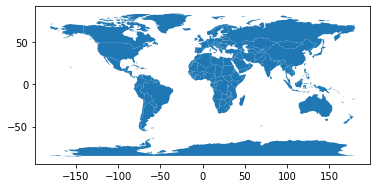

In [50]:
import descartes

# Test plot the countries with GeoPandas Descartes library
countries.plot()

1. Da in diesem Teilversuch nur die Lebenserwartung in 2015 betrachtet werden, sind nur diese Zeilen aus dem angelegten Dataframe zu berücksichtigen.
2. Vereinigen Sie die Polygondaten aus dem Dataframe `countries` mit dem Dataframe `general_information`. Achten Sie hierbei, dass Sie den *pandas dataframe* in den *geopandas dataframe* mergen, das Resultat also ein *geopandas dataframe* mergen ist (andernfalls funktioniert der nächste Schritt nicht). 

In [51]:
# Aufgabe 1:
# Query database to retrieve the data for life expectancy in the year 2015
query = """SELECT "Entity", "Code", "Year","LifeExpectancy" FROM general_information WHERE "Year"= '2015'"""
general_information_2015 = pd.read_sql_query(query,engine)

# Adjust names for the values of "Entity" and "Code" to "name" and "id"
general_information_2015.rename(columns={"Code":"id"}, inplace=True)
general_information_2015.count()
# Check the new values
print ('The new name-values are \n{}'.format(general_information_2015))


The new name-values are 
                  Entity        id  Year  LifeExpectancy
0            Afghanistan       AFG  2015       63.287998
1                Albania       ALB  2015       78.174004
2                Algeria       DZA  2015       75.860001
3                 Angola       AGO  2015       61.241001
4    Antigua and Barbuda       ATG  2015       76.207001
..                   ...       ...   ...             ...
198       Western Sahara       ESH  2015       69.212997
199                World  OWID_WRL  2015       71.429001
200                Yemen       YEM  2015       64.742996
201               Zambia       ZMB  2015       61.396999
202             Zimbabwe       ZWE  2015       60.397999

[203 rows x 4 columns]


In [52]:
# Merge the two dataframes into a GeoDataFrame
countriesMerged = countries.merge(general_information_2015, how='left', on=["id"])
#print('The merged GeoDataFrame values are \n{}'.format(countriesMerged))


5. Durch Aufruf der Methode `to_json()` kann ein Dataframe in json transformiert werden. Die von der Methode zurückgegebenen Daten können einem [Bokeh GeoJSONDataSource](https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html#geojson-data)-Objekt beim Anlegen übergeben werden. Das *GeoJSONDataSource*-Objekt kann direkt der entsprechenden Bokeh-plotting Funktion übergeben werden. Erzeugen Sie mit diesen Hinweisen einen interaktiven Weltkartenplot der oben dargestellten Art. Beim *Mouse-Over* über ein Land soll der Name des Landes und die Lebenserwartung angezeigt werden.
> Alternative: Eine einfachere Lösung für die Geovisualisierung bietet [geopandas](http://geopandas.org/mapping.html). Allerdings sind damit keine interaktiven Elemente realisierbar. 
6. Diskutieren Sie die aus der Visualisierung gewonnenen Erkenntnisse.

In [53]:
# Write the GeoPandaFrame to GeoJSON file format
countriesMerged.to_file("../data/json/lifeexp_geodata_2015.json", driver="GeoJSON")

In [54]:
# Import all required modules to render the interactive map in Bokeh
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import Viridis256
import json

### Bokeh Library for interactive maps
The merged files result in a _GeoDataframe_ object, which can be represented by using a geopandas module. For in interactive visualization _Bokeh_ library is used. Bokeh consumes _GeoJSON_ format, which represents geographical features with JSON. GeoJSON describes points, lines and polygones (_Patches_) as a collection of features. Therefore the merged files are converted to a GeoJSON format.

In [55]:
# Path to the geographical data stored in a .json file
#PATH = '../data/json/lifeexp_geodata_2015.json'
# Load GeoJson data from source
#data = gpd.read_file(PATH).to_json()
#print(data)

In [56]:
# Convert the GeoJson data to a string-like object
# geo_source = GeoJSONDataSource(geojson=json.dumps(data))

#GeoJSONDataSource Objekt erstellen
data = json.loads(countriesMerged.to_json())
geo_source = GeoJSONDataSource(geojson=json.dumps(data))

# Check the converted data
#print(geo_source)

In [57]:
#Bokeh ausgabe im Notebook
output_notebook()

#Tooltip für Mouse-Over
TOOLTIPS = [
    ('Land', '@name'),
    ('Lebenserwartung', '@LifeExpectancy')
]

#Color Mapper für farbliche Visualisierung erstellen
#Viridis256.reverse()
Viridis256 = tuple(reversed(Viridis256))
color_mapper = LinearColorMapper(palette=Viridis256, low=countriesMerged.LifeExpectancy.min(), high=countriesMerged.LifeExpectancy.max())
color_mapper.low_color = "grey"

#Color bar als Legende
color_bar = ColorBar(color_mapper=color_mapper, 
                     label_standoff=12, border_line_color=None, location=(0,0))



#bokeh figure anlegen, mit zuvor erstelltem tooltip
p = figure (background_fill_color="lightgrey", plot_height = 600, plot_width= 1200, tooltips=TOOLTIPS)

#Länder hinzufügen mit farblich codierter Lebenserwartung
p.patches('xs', 'ys', source=geo_source, line_color="black", line_width=0.25, fill_alpha=1, fill_color = {'field' :'LifeExpectancy', 'transform' : color_mapper})

#Color bar der bokeh figure hinzufügen
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

# Ergebnis der Visualisierung

Auf der mittels Bokeh visualisierten Weltkarte sind die Lebenserwartungen je Land dargestellt. Hierbei werden die einzelnen Länder mit einer Farbskala von dunkel-lila bis hell-gelb eingefärbt. Je dunkler die Farbgebung, desto höher die Lebenserwartung.

Bei der Analyse der Weltkarte ist besonders auffällig, dass sowohl für Serbien, Somalia, Grönland, als auch Antarktika (sowie kleinere 
Inseln) keine Daten in der CSV Datei vorhanden sind. Diese werden hier grau dargestellt. Dagegen ist die Lebenserwartung in hauptsächlich westlichen Nationen, wie Japan (~ ca. 83 Jahre), Australien (~ ca. 82.7 Jahre), Kanada (~ ca. 82.5 Jahre), Neuseeland (~ ca. 81 Jahre), als auch Zentral-Europa am höchsten. Die niedrigste Lebenserwartungen sind vor allem in Zentral-Afrika (~ ca. 50 - 60 Jahre), Indien (~ ca. 68 Jahre), sowie Russland (~ ca. 70.9 Jahre), als auch dem Süden Asiens zu verzeichnen. 

Der Weltkarte nicht entnehmbar sind dabei politische, als auch gesellschaftliche Entwicklungen. Dennoch kann man aus dem Allgemeinwissen heraus schließen, dass sich die Geschichte u.A. Kolonialisierung der Länder in der Vergangenheit stark auf die Lebenserwartung und den Wohlstand in der Bevölkerung ausgewirkt hat. 

## Korrelation der Lebenserwartung mit volkswirtschaftlichen Metriken
In diesem Abschnitt soll die paarweise Korrelation von 
* `GDPperCapita`
* `AnnualHealthcarExpPerCapita`

mit der `LifeExpectancy` untersucht werden. 

1. Für die visuelle Korrelationsanalyse erzeugen Sie je einen Scatterplot, in dem `LifeExpectancy` über `GDPperCapita` bzw. über `AnnualHealthcarExpPerCapita` dargestellt ist.
2. Berechnen Sie mit der `numpy`-Funktion `corrcoef` die beiden paarweisen Korrelationen. 
3. Diskutieren Sie das Ergebnis.

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt

# Use Panda Core

#### Visual Correlation Analysis

### Berechnung des Korrelationskoeffizienten ( _Pearson Korrelation_ )
Der Korrelationskoeffizient wird auch als _Produkt-Moment-Korrelation_ benannt. Dies ist ein Maß für den Grad des linearen Zusammenhangs zwischen zwei mindestens intervallskalierten Merkmalen, das nicht von den Maßeinheiten der MEssung abhängt und somit dimensionslos ist. Dieser kann einen Wert zwischen ``` 1 ``` und ```-1 ``` annehmen. 

## Korrelation der Lebenserwartung mit Ernährungsdaten
Untersuchen Sie dann so wie im vorigen Abschnitt wie die einzelnen Nuitrition-Merkmale mit der `LifeExpectancy` korrelieren. Diskutieren Sie das Ergebnis.

## Time Series Analysis

Auf der Basis des Dataframes `nutrition_information`: Stellen Sie die zeitliche Entwicklung des Merkmals
1. `KcalFat` 
2. `DailyCaloriesPerCapita` 

von 1995 bis 2015 für die Länder Bolivia, Bulgaria, Egypt, Kenya, United States, China, Brazil, Germany graphisch dar. Erzeugen Sie hierfür pro Merkmal einen Plot, in dem die Linegraphs aller genannten Länder dargestellt sind. 

Interpretieren Sie diese Darstellungen

In [123]:
# Query the SQL database for 'KcalFat' as well as 'DailyCaloriesPerCapita'
query="""SELECT "Entity", "Code", "Year", "KcalFat","DailyCaloriesPerCapita" 
FROM nutrition_information WHERE "Entity" IN ('Bolivia', 'Bulgaria', 'Egypt', 'Kenya', 'United States', 'China', 'Brazil', 'Germany') """
df_nutrition_information=pd.read_sql_query(query, engine)
print(df_nutrition_information)

           Entity Code  Year  DailyCaloriesPerCapita
0     Afghanistan  AFG  1961                  2999.0
1     Afghanistan  AFG  1962                  2917.0
2     Afghanistan  AFG  1963                  2698.0
3     Afghanistan  AFG  1964                  2953.0
4     Afghanistan  AFG  1965                  2956.0
...           ...  ...   ...                     ...
9546     Zimbabwe  ZWE  2009                  2147.0
9547     Zimbabwe  ZWE  2010                  2168.0
9548     Zimbabwe  ZWE  2011                  2200.0
9549     Zimbabwe  ZWE  2012                  2197.0
9550     Zimbabwe  ZWE  2013                  2110.0

[9119 rows x 4 columns]


In [124]:
# Data preprocessing
# Drop all rows where there are NaN values
nutrition_information = df_nutrition_information[df_nutrition_information[[
    'KcalFat', 'DailyCaloriesPerCapita']].notnull().all(1)]

# Analyse the head and tail of the dataframe
nutrition_information.head(5)

,Entity,Code,Year,KcalFat,DailyCaloriesPerCapita
17,Bolivia,BOL,1961,312.21,1732.0
18,Bolivia,BOL,1962,307.98,1761.0
19,Bolivia,BOL,1963,321.75,1810.0
20,Bolivia,BOL,1964,328.14,1744.0
21,Bolivia,BOL,1965,321.39,1831.0


#### Indexing with Time Series Data

In [125]:
# Creating a datetime index for the dataframe
nutrition_information.index = nutrition_information['Year']
nutrition_information = nutrition_information.drop(columns=['Year'])

# Summary of the dataset
nutrition_information.isnull().sum()

Entity                    0
Code                      0
KcalFat                   0
DailyCaloriesPerCapita    0
dtype: int64

In [126]:
nutrition_information.head()

,Entity,Code,KcalFat,DailyCaloriesPerCapita
Year,,,,
1961,Bolivia,BOL,312.21,1732.0
1962,Bolivia,BOL,307.98,1761.0
1963,Bolivia,BOL,321.75,1810.0
1964,Bolivia,BOL,328.14,1744.0
1965,Bolivia,BOL,321.39,1831.0


In [116]:
# List of countries for time series analysis
countries = ['Bolivia', 'Bulgaria', 'Egypt', 'Kenya', 'United States', 'China', 'Brazil', 'Germany']

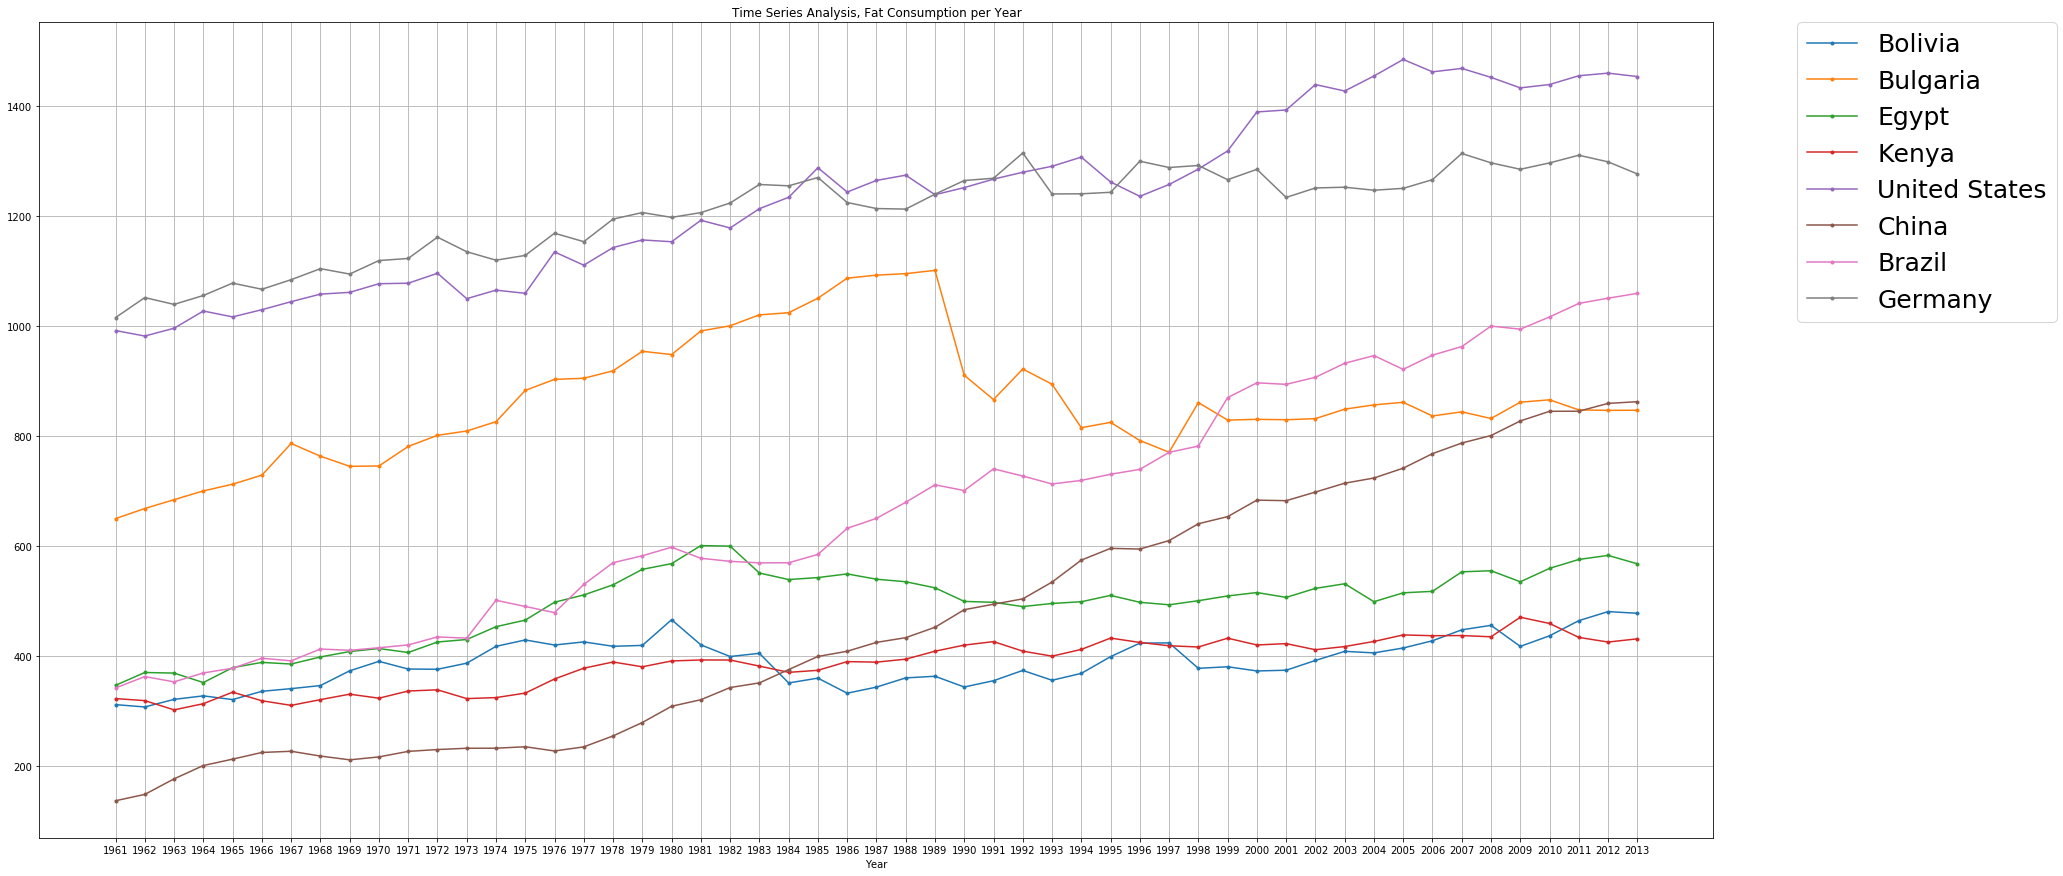

In [158]:
# Draw Plot to check values in time series
ax = plt.gca()
for country in countries:
    y = nutrition_information.loc[nutrition_information['Entity'] == country]
    y = y['KcalFat']
    y.plot(kind='line', marker='.', xticks=y.index, x='Year', y='Fat consumption in Kcal', 
           title='Time Series Analysis, Fat Consumption per Year', figsize=(30,15), grid=True, ax=ax)
plt.legend(countries, fontsize=25, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

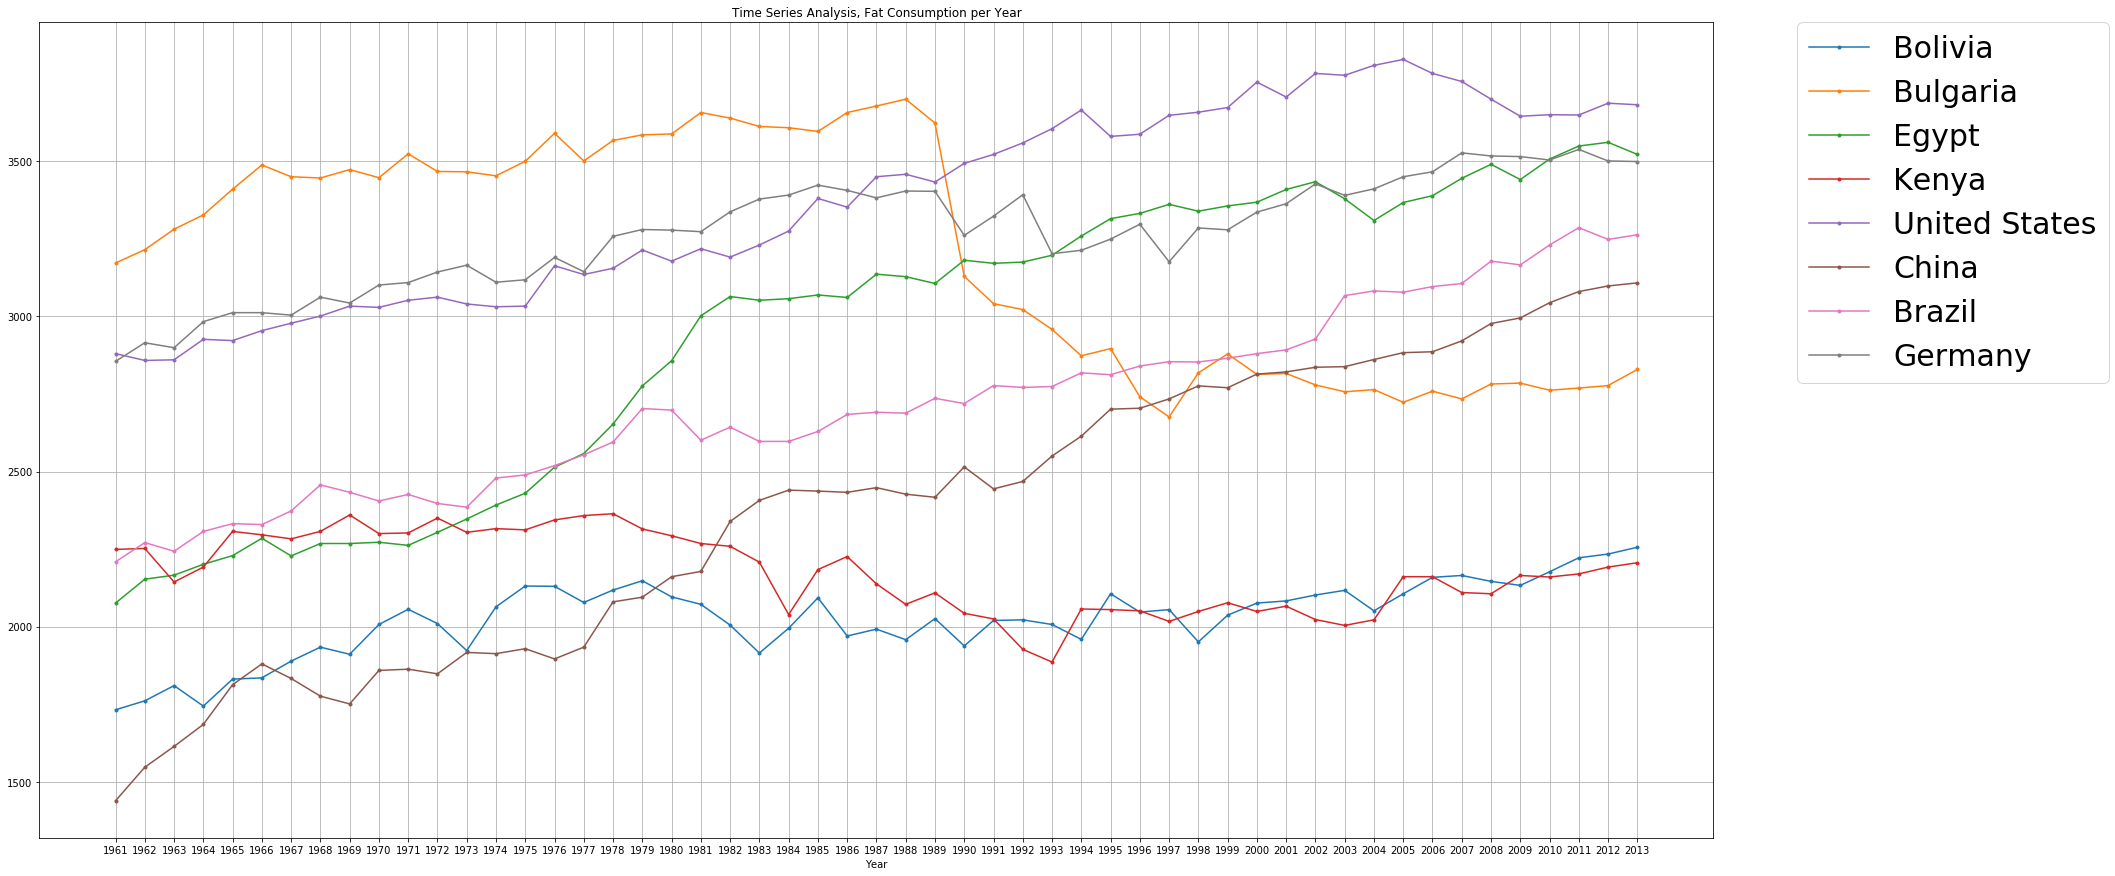

In [157]:
# Draw Plot to check values in time series
ax = plt.gca()
for country in countries:
    y = nutrition_information.loc[nutrition_information['Entity'] == country]
    y = y['DailyCaloriesPerCapita']
    y.plot(kind='line', marker='.', xticks=y.index, x='Year', y='Fat consumption in Kcal', 
           title='Time Series Analysis, Daily Calories per Capita and Year', figsize=(30,15), grid=True, ax=ax)
plt.legend(countries, fontsize=25, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Interpretation der Darstellung

Die zu untersuchende, erste Grafik '_Time Series Analysis, Annual Fat Consumption (Kcal)_ ', als auch die zweite Grafik [2] '_Time Series Analysis, daily Calories per Capita_' zeigen die Entwicklung des jährlichen Kalorien-, als auch Fett Konsums in den zu untersuchenden Ländern Bolivien, Bulgarien, Ägypten, Kenya, den Vereinigten Amerikanischen Staaten, China, Brasilien, sowie Deutschland zwischen den Jahren 1995 und 2013 auf.

#### [G1] Time Series Analysis, Annual Fat Consumption (Kcal)
Bei der Analyse der ersten Grafik ist ein Trend zu einem positiv ansteigenden Konsum an Fetten zu verzeichnen. Während die westlichen Nationen Deutschland, als auch Nordamerika (USA) sich zu Beginn der Darstellung (1995 - 2000) noch stark von den anderen Ländern in ihrem Konsumverhalten unterscheiden, folgt insbesondere Brasilien dem Trend und überschreitet ab 2008 die 1000 Kcal Grenze, welche bis dahin von keinem der Schwellenländer überschritten wurde. Die Schwellenländer Bolivien, Ägypten,  als auch Kenya verzeichnen auf der anderen Seite den geringsten Konsum an Fetten. Dennnoch findet auch hier ein leichter Aufwärtstrend statt.

Von Interesse ist ebenso, dass, während alle anderen Länder eine starke Differenz zu westlichen Nationen, wie Deutschland und den USA verzeichnen, hier eine Trendwende zu beobachten ist und ab dem Jahr 2007 gar eine zunehmende Annäherung an eine Sättigungsgrenze zu erkennen ist. Während Deutschland bis zum Jahr 1998 noch Spitzenreiter ist und vor allen anderen Ländern beim Konsum an Fetten liegt, überholt die USA Deutschland mit einem starken Wachstum, welcher jedoch ab dem Jahr 2005 rückläufig wird.

Man könnte daraus schließen, dass mit zunehmendem wirtschaftlichen Wachstum, auch die finanzielle Fähigkeit einer umfänglicheren Ernährung in der Bevölkerung wächst. Ebenso kann man hier Rückschlüsse auf den Gesundheitszustand, im Betreff des BMI anstreben. Gesundheitsprobleme, welche aus einer zunehmenden Industrialisierung der einzelnen Länder hervorgehen, könnten auch die Ursache für eine zunehmende Kertwende und eine Abflachung der Kurse in westlichen Ländern erklären. 

###### Time Series Analysis, Daily Calories per Capita
Bei der Analyse der zweiten Grafik[2] zeichnet sich im Gesamtüberblick ebenso ein steigender Trend ab. So Konsumieren Nord-Amerikaner nach wie vor die meisten Kalorien, haben aber auch im Kalorien-Konsum einen rückläufigen Trend seit dem Jahr 2005 zu verzeichnen. Während Ägypten einen verhältnismäßig eher geringen Konsum an Fetten hat, so wird hier dennoch eine hohe Anzahl an Kalorien/Tag konsumiert. Die beiden Kurven der USA, als auch Ägypten nähern sich dabei stark an. Auch Deutschland zählt zu den Ländern mit einem relativ hohen Kalorien Verbrauch. Dagegen liegt Bolivien mit Kenya auf dem untersten Level mit nur 2000 - 2250 Kalorien pro Tag/Capita. 

Ein Zusammenhang mit der wirtschaftlichen Lage der jeweiligen Länder ist nahe liegend.

## Jahr mit den meisten non-Nans
1. Bestimmen Sie das Jahr, für das am meisten non-Nans in dem in der vorigen Teilaufgabe erstellten Dataframe `nutrition_information` existieren.
2. Erstellen Sie einen neuen Dataframe, der nur die non-Nan Daten für das zuvor bestimmte Jahr enthält.
3. Mergen Sie diesen neuen Dataframe mit dem Dataframe `general_information` ohne die Spalte `AnnualWorkingHourPerPerson`. Der so gebildete Dataframe wird im Weiteren mit `data_nut_gen` bezeichnet.

In [68]:
# Aufgabe 1

# Neues DataFrame das alle Jahre und die Anzahl der non-Nans in dieser Spalte enthält
df = pd.DataFrame()
df['Year'] = nutrition_information['Year']
df['non-Nan'] = nutrition_information.count(axis=1)   

lst = []

# Maximale Anzahl an Spalten die nicht Null sind
maximal = df["non-Nan"].max()

for label, row in df.iterrows():
    # Wenn die Anzahl an non-Nans nicht der maximalen entspricht wird es der Liste 'lst' angefügt
    if row[1] != maximal:
        lst.append(label)

for item in lst:
    # Löscht alle Reihen deren Index in der Liste 'lst' enthalten sind
    df.drop([item], axis=0, inplace=True)
    
# Array mit allen Jahren die die meisten non-Null Werte haben
df['Year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 1947, 1948,
       1800, 1812, 1846, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1930,
       1934, 1946, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1705, 1820, 1830, 1840, 1920, 1810, 1270, 1300, 1310, 1380, 1420,
       1450, 1600, 1700, 1750, 1940, 1950], dtype=int64)

In [69]:
# Aufgabe 2
# Wir haben uns für das Jahr 2013 entschieden

# Datenbankabfrage um alle Daten von der table 'nutrition_information' vom Jahr 2013 zu selektieren
query = """SELECT "Entity", "Code", "Year","LifeExpectancy","AnnualFruitConsumptionPerCapita", "AnnualVegetableConsumptionPerCapita",
"KcalOther","KcalSugar","KcalOilsFats" FROM nutrition_information WHERE "Year"= '2013'"""
df_2013 = pd.read_sql_query(query,engine)

# Datenbankabfrage um alle Daten außer 'AnnualWorkingHourPerPerson' von der table 'general_information' vom Jahr 2013 zu selektieren
query = """SELECT "Entity", "Code", "Year","LifeExpectancy","GDPperCapita","AnnualHealthcarExpPerCapita" FROM general_information WHERE "Year"= '2013'"""
general_information_2013 = pd.read_sql_query(query,engine)

In [70]:
# Aufgabe 3

# Merge vom DataFrame df_2013  und general_information_2013 
data_nut_gen = general_information_2013.merge(df_2013, how="left", on=["Entity","Code","Year","LifeExpectancy"])
data_nut_gen

,Entity,Code,Year,LifeExpectancy,GDPperCapita,AnnualHealthcarExpPerCapita,AnnualFruitConsumptionPerCapita,AnnualVegetableConsumptionPerCapita,KcalOther,KcalSugar,KcalOilsFats
0,Afghanistan,AFG,2013,62.493999,1814.155825,156.529349,34.05,28.97,15.0,87.0,149.0
1,Albania,ALB,2013,77.702003,10504.093089,564.065965,142.00,245.09,33.0,197.0,322.0
2,Algeria,DZA,2013,75.417999,13253.217515,858.860356,114.19,165.70,36.0,265.0,409.0
3,Angola,AGO,2013,60.373001,6185.013829,301.989149,90.34,67.66,13.0,146.0,268.0
4,Antigua and Barbuda,ATG,2013,75.891998,18862.816760,1121.228751,157.78,74.32,62.0,302.0,321.0
...,...,...,...,...,...,...,...,...,...,...,...
198,Western Sahara,ESH,2013,68.565002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,World,OWID_WRL,2013,70.919998,14109.738979,1220.691334,77.87,140.48,NaN,NaN,NaN
200,Yemen,YEM,2013,64.291000,3872.789957,211.042840,52.64,31.14,26.0,273.0,229.0
201,Zambia,ZMB,2013,59.981998,3576.680691,186.891991,10.23,25.76,7.0,100.0,266.0


## Dimensionsreduktion mit PCA und TSNE

Der oben konstruierte Dataframe `data_nut_gen` sollte ausschließlich non-NAN Werte haben und Daten nur eines Jahres enthalten. Alle Spalten von `data_nut_gen`, außer `Entity`, `Code`, `Year` und `LifeExpectancy` werden im Folgenden als *Merkmalsspalten* bezeichnet.

1. Führen Sie auf dem numpy-Array, das nur die Werte der *Merkmalspalten* enthält, eine Principal Component Analysis mit dem entsprechenden [scikit-learn Modul PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) durch. Bestimmen Sie die zwei Hauptachsen. 
2. Bestimmen Sie für das trainierte Modell den `explained_variance_ratio`. Was sagen diese Zahlen aus?
2. Stellen Sie die auf die 2 Hauptachsen transformierten Daten der Merkmalsspalten von `data_nut_gen` in einem Bokeh-Plot dar. In diesem soll die Farbe der Punkte durch die Werte der Spalte `LifeExpectancy` codiert werden.
3. Führen Sie nun eine Dimensionalitätsreduktion mit dem [scikit-learn Modul TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) auf 2 Achsen durch. Visualisieren Sie auch dieses Resultat mit einem Bokeh-Plot (wie in Teilaufgabe 2).
4. Diskutieren Sie das Ergebnis der beiden Dimensionsreduktionen.

## Regression
Im Folgenden soll aus den Merkmalsspalten das Dataframes `data_nut_gen` die Lebenserwartung (Spalte `LifeExpectancy`) vorhergesagt werden.
1. Partitionieren Sie die Daten mit der [scikit-learn Methode](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), so dass $2/3$ der Daten für das Training und der Rest für den Test verwendet werden.
2. Trainieren Sie [ein lineares Regressionsmodell](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) mit den Trainingsdaten und bestimmen Sie den *Mean-Absolute-Error* und den *R2*-Score auf Trainings- und Testdaten.
3. Wie kann mit dem trainierten Linear-Regression Modell auf die Bedeutung (Wichtigkeit) der verwendeten Merkmale geschlossen werden. 
3. Trainieren Sie nun einen [Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) und bestimmen Sie wieder *Mean-Absolute-Error* und den *R2*-Score auf Trainings- und Testdaten.
3. Wie kann mit dem trainierten Random-Forest Modell auf die Bedeutung (Wichtigkeit) der verwendeten Merkmale geschlossen werden. 
4. Was ist der *R2-Score*?
4. Diskutieren Sie die Ergebnisse

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error

### Preparing Data for Linear Regression

* Linear Assumption. Linear regression assumes that the relationship between your input and output is linear. 
* Remove Noise. Linear regression assumes that the input and output variables are not noisy. This is most important for the output variable. 


In [ ]:
# Preprocessing the data and imputing all NaN values


In [94]:
# 1. Aufgabe - Partitionieren der Lifeexpextancy Daten des 'data_nut_gen'DataFrame in 2/3 Test und Trainingsdaten
np_df = data_nut_gen.to_numpy()
# X= input variables or Merkmalsspalten, y = output variable 'LifeExpectancy'
X, y = np_df[:, 4:12], np_df[:, 3]
# Split training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Split val and test data
y_val = train_test_split(y, shuffle=True)

In [ ]:
# 2. Aufgabe Trainieren Sie ein lineares Regressionsmodell mit den Trainingsdaten und bestimmen Sie den Mean-Absolute-Error und den R2-Score auf Trainings- und Testdaten.
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


In [ ]:
# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Clustering der Länder nach Ihrem Pro-Kopf-Kalorienverbrauch
1. Bestimmen Sie zunächst alle Länder für die das Merkmal `DailyCaloriesPerCapita` im Dataframe `nutrition_information` für alle Jahre von 1960 bis 2012 einen Wert hat. Konstruieren Sie dann ein numpy-Array $X$, in dem das Element $C_{i,j}$ in Zeile $i$, Spalte $j$, den `DailyCaloriesPerCapita`-Wert des Landes $i$ im $j.ten$ Jahr zwischen 1960 und 2012 enthält.
2. Clustern Sie die Länder nach ihrer zeitlichen Entwicklung des `DailyCaloriesPerCapita`-Wertes - also die Zeilen des Arrays $X$. Verwenden Sie hierfür den [K-Means Algorithmus von scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Stellen Sie dabei die Clusteranzahl auf $k=5$ ein. 
3. Für jedes der $k=5$ Cluster: Erzeugen Sie einen Plot, in dem der zeitliche Verlauf des `DailyCaloriesPerCapita`-Wertes aller zum jeweiligen Cluster gehörenden Länder als Line-Graph dargestellt ist.
4. Charakterisieren Sie die 5 Cluster anhand der clusterspezifischen Visualisierung.
    

In [ ]:
from sklearn.cluster import KMeans